# <center><font color='magenta'>**Assignment 3: Forecasting Time Series**</font></center>
### <center>Enkhsaikhan Usny-Ekh</center>

In [1]:
import pandas as pd
import numpy as np
import warnings
import sys
import os
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from patsy import dmatrices
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm

warnings.filterwarnings("ignore")

In [2]:
try:
    from pmdarima.arima import auto_arima
except:
    !pip install pmdarima
    from pmdarima.arima import auto_arima

### <span style="color:blue"><b>1. Data cleaning</b></span>

In [3]:
data = pd.read_csv("https://raw.githubusercontent.com/Enkhsaikhan-u/DA3-Assignment-3-Forecasting/refs/heads/main/data.csv")

In [4]:
data

,ts,v1,v2
0,2022-01-01 00:00:00,0.999036,0.318587
1,2022-01-01 01:00:00,0.695036,0.265836
2,2022-01-01 02:00:00,0.764995,0.320261
3,2022-01-01 03:00:00,0.297017,0.064074
4,2022-01-01 04:00:00,0.366184,0.083961
...,...,...,...
24587,2024-10-31 19:00:00,1.152634,0.368448
24588,2024-10-31 20:00:00,1.228804,0.322425
24589,2024-10-31 21:00:00,1.281062,0.361132
24590,2024-10-31 22:00:00,1.150800,0.313283


In [5]:
data["ts"] = pd.to_datetime(data.ts)

#### Year, month, week, weekend and time variables

In [6]:
data["year"] = data["ts"].dt.year
data["quarter"] = data["ts"].dt.quarter
data["month"] = data["ts"].dt.month
data["day"] = data["ts"].dt.day
data["dow"] = data["ts"].dt.dayofweek +1
data["weekend"] = data["dow"].isin([6, 7])
data['time'] = data["ts"].dt.time

In [7]:
data["trend"] = data.index + 1 

In [8]:
data.head()

,ts,v1,v2,year,quarter,month,day,dow,weekend,time,trend
0,2022-01-01 00:00:00,0.999036,0.318587,2022,1,1,1,6,True,00:00:00,1
1,2022-01-01 01:00:00,0.695036,0.265836,2022,1,1,1,6,True,01:00:00,2
2,2022-01-01 02:00:00,0.764995,0.320261,2022,1,1,1,6,True,02:00:00,3
3,2022-01-01 03:00:00,0.297017,0.064074,2022,1,1,1,6,True,03:00:00,4
4,2022-01-01 04:00:00,0.366184,0.083961,2022,1,1,1,6,True,04:00:00,5


In [9]:
data.year.value_counts()

year
2023    8734
2022    8613
2024    7245
Name: count, dtype: int64

Holidays

In [10]:
import pandas_market_calendars as mcal

nyse = mcal.get_calendar("NYSE")
holidays = nyse.holidays().holidays

In [11]:
minyear = data.ts.min().year
maxyear = data.ts.max().year

In [12]:
import holidays

usholidays = holidays.UnitedStates(years = [x for x in range(minyear, maxyear + 1, 1)])

In [13]:
for dat in usholidays.items():
    print(dat)

(datetime.date(2024, 1, 1), "New Year's Day")
(datetime.date(2024, 5, 27), 'Memorial Day')
(datetime.date(2024, 6, 19), 'Juneteenth National Independence Day')
(datetime.date(2024, 7, 4), 'Independence Day')
(datetime.date(2024, 9, 2), 'Labor Day')
(datetime.date(2024, 11, 11), 'Veterans Day')
(datetime.date(2024, 11, 28), 'Thanksgiving')
(datetime.date(2024, 12, 25), 'Christmas Day')
(datetime.date(2024, 1, 15), 'Martin Luther King Jr. Day')
(datetime.date(2024, 2, 19), "Washington's Birthday")
(datetime.date(2024, 10, 14), 'Columbus Day')
(datetime.date(2022, 1, 1), "New Year's Day")
(datetime.date(2022, 5, 30), 'Memorial Day')
(datetime.date(2022, 6, 19), 'Juneteenth National Independence Day')
(datetime.date(2022, 6, 20), 'Juneteenth National Independence Day (observed)')
(datetime.date(2022, 7, 4), 'Independence Day')
(datetime.date(2022, 9, 5), 'Labor Day')
(datetime.date(2022, 11, 11), 'Veterans Day')
(datetime.date(2022, 11, 24), 'Thanksgiving')
(datetime.date(2022, 12, 25), 'C

In [14]:
holiday_days = [x[0] for x in usholidays.items()]
holiday_days[0:10]

[datetime.date(2024, 1, 1),
 datetime.date(2024, 5, 27),
 datetime.date(2024, 6, 19),
 datetime.date(2024, 7, 4),
 datetime.date(2024, 9, 2),
 datetime.date(2024, 11, 11),
 datetime.date(2024, 11, 28),
 datetime.date(2024, 12, 25),
 datetime.date(2024, 1, 15),
 datetime.date(2024, 2, 19)]

In [15]:
data["holiday"] = data["ts"].isin(holiday_days)

### <span style="color:blue"><b>2. Data analysis and graphs</b></span>

In [16]:
filtered_data = data[data["ts"].dt.date == pd.Timestamp("2022-01-01").date()]

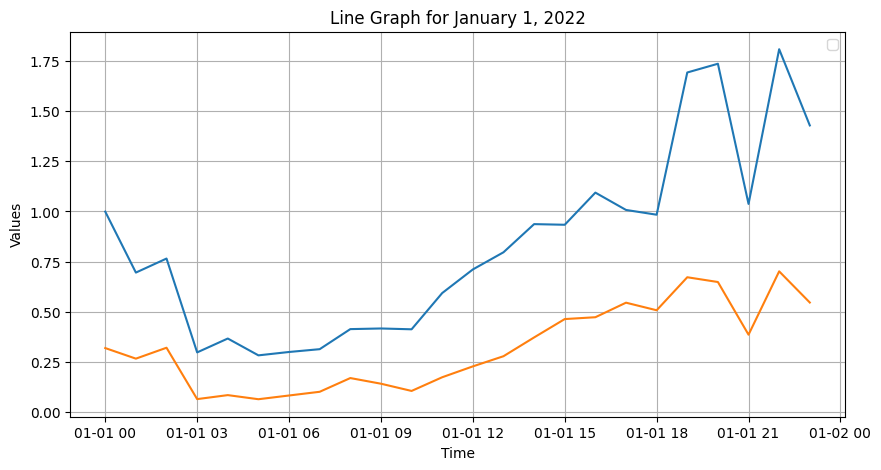

In [17]:
plt.figure(figsize=(10, 5))
plt.plot(filtered_data["ts"], filtered_data["v1"])
plt.plot(filtered_data["ts"], filtered_data["v2"])

plt.xlabel("Time")
plt.ylabel("Values")
plt.title("Line Graph for January 1, 2022")
plt.legend()
plt.grid()

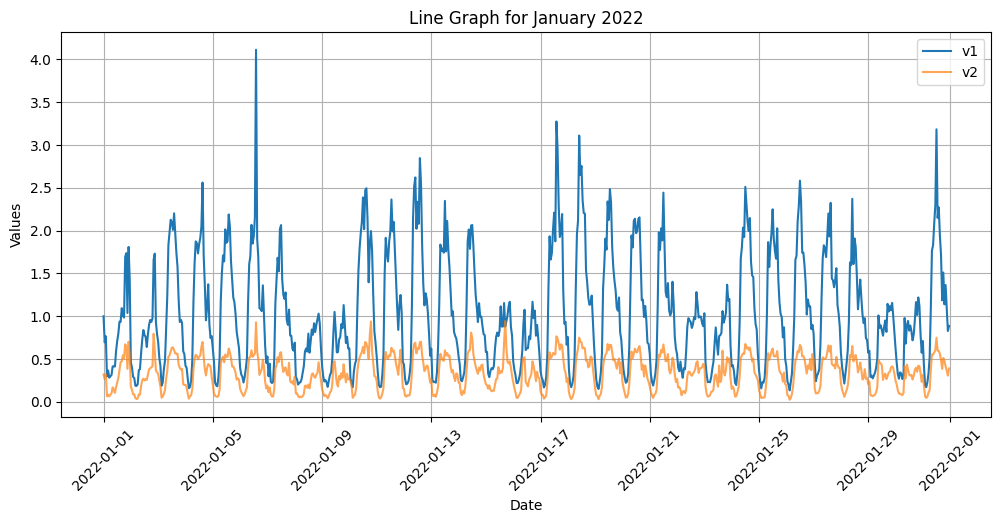

In [18]:
filtered_data_m = data[(data["ts"].dt.year == 2022) & (data["ts"].dt.month == 1)]
# Create the plot
plt.figure(figsize=(12, 5))
plt.plot(filtered_data_m["ts"], filtered_data_m["v1"], label="v1")
plt.plot(filtered_data_m["ts"], filtered_data_m["v2"], label="v2", alpha=0.7)

# Formatting
plt.xlabel("Date")
plt.ylabel("Values")
plt.title("Line Graph for January 2022")
plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.legend()
plt.grid()

#### Distribution by month

Text(0.5, 1.0, 'Distribution of v2 by month')

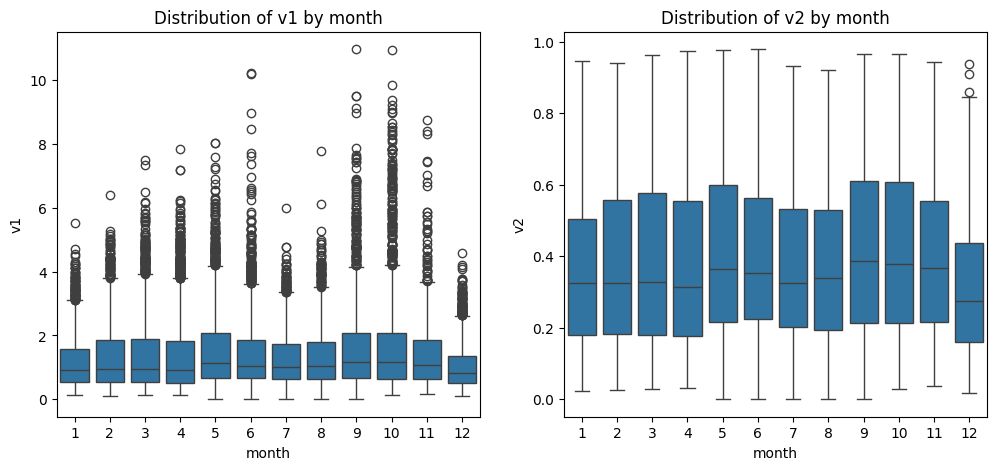

In [19]:
fig, ax = plt.subplots(1, 2, figsize = (12, 5))

sns.boxplot(data= data, x = 'month', y = 'v1', ax = ax[0])
ax[0].set_title('Distribution of v1 by month')

sns.boxplot(data= data, x = "month", y = "v2", ax=ax[1])
ax[1].set_title("Distribution of v2 by month")

#### Distribution by day of the week

Text(0.5, 1.0, 'Distribution of v2 by dow')

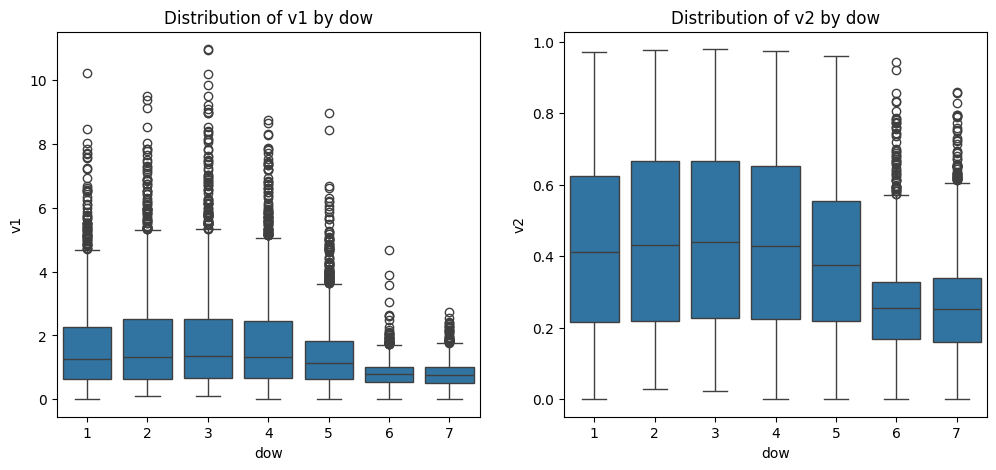

In [20]:
fig, ax = plt.subplots(1, 2, figsize = (12, 5))

sns.boxplot(data= data, x = 'dow', y = 'v1', ax = ax[0])
ax[0].set_title('Distribution of v1 by dow')

sns.boxplot(data= data, x = "dow", y = "v2", ax=ax[1])
ax[1].set_title("Distribution of v2 by dow")

#### Distribution by time

[Text(0, 0, '00:00:00'),
 Text(1, 0, '01:00:00'),
 Text(2, 0, '02:00:00'),
 Text(3, 0, '03:00:00'),
 Text(4, 0, '04:00:00'),
 Text(5, 0, '05:00:00'),
 Text(6, 0, '06:00:00'),
 Text(7, 0, '07:00:00'),
 Text(8, 0, '08:00:00'),
 Text(9, 0, '09:00:00'),
 Text(10, 0, '10:00:00'),
 Text(11, 0, '11:00:00'),
 Text(12, 0, '12:00:00'),
 Text(13, 0, '13:00:00'),
 Text(14, 0, '14:00:00'),
 Text(15, 0, '15:00:00'),
 Text(16, 0, '16:00:00'),
 Text(17, 0, '17:00:00'),
 Text(18, 0, '18:00:00'),
 Text(19, 0, '19:00:00'),
 Text(20, 0, '20:00:00'),
 Text(21, 0, '21:00:00'),
 Text(22, 0, '22:00:00'),
 Text(23, 0, '23:00:00')]

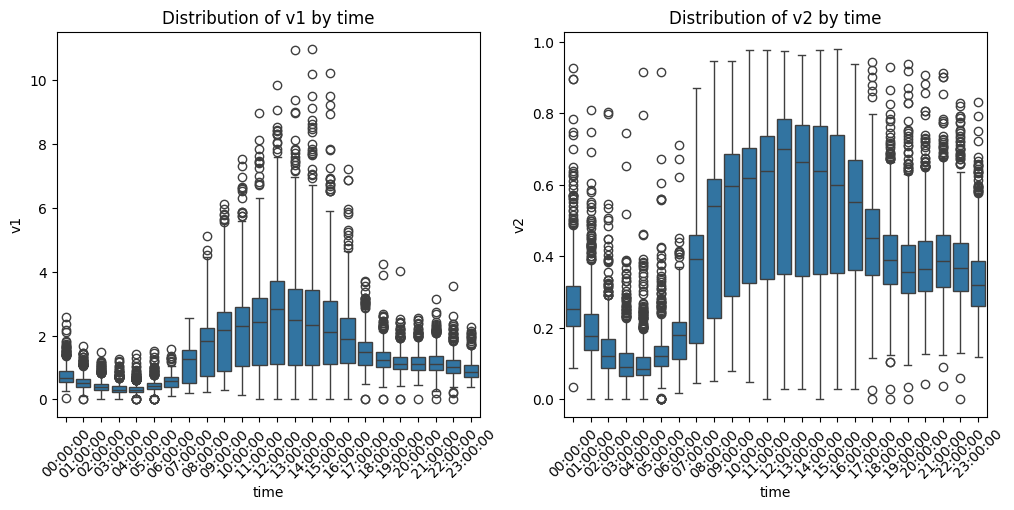

In [21]:
fig, ax = plt.subplots(1, 2, figsize = (12, 5))

sns.boxplot(data= data, x = 'time', y = 'v1', ax = ax[0])
ax[0].set_title('Distribution of v1 by time')
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45)

sns.boxplot(data= data, x = "time", y = "v2", ax=ax[1])
ax[1].set_title("Distribution of v2 by time")
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=45)

<Axes: xlabel='time', ylabel='dow'>

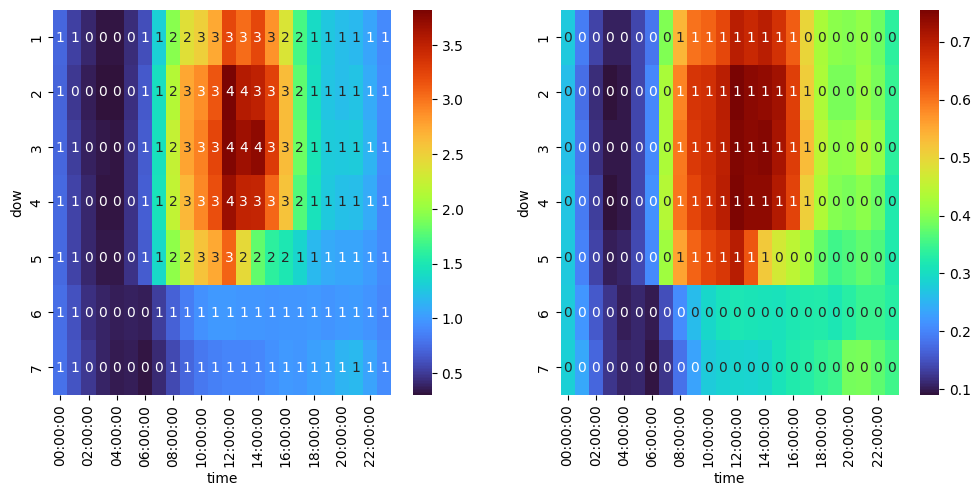

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(
    data = data.pivot_table(index="dow", columns="time", values="v1", aggfunc='mean'), 
    annot = True, 
    cmap = 'turbo',
    # cmap = 'coolwarm',
    fmt = '.0f',
    ax=ax[0])

sns.heatmap(
    data = data.pivot_table(index="dow", columns="time", values="v2", aggfunc = "mean"),
    annot= True,
    cmap= "turbo",
    fmt = ".0f",
    ax = ax[1]
)

<Axes: xlabel='dow', ylabel='month'>

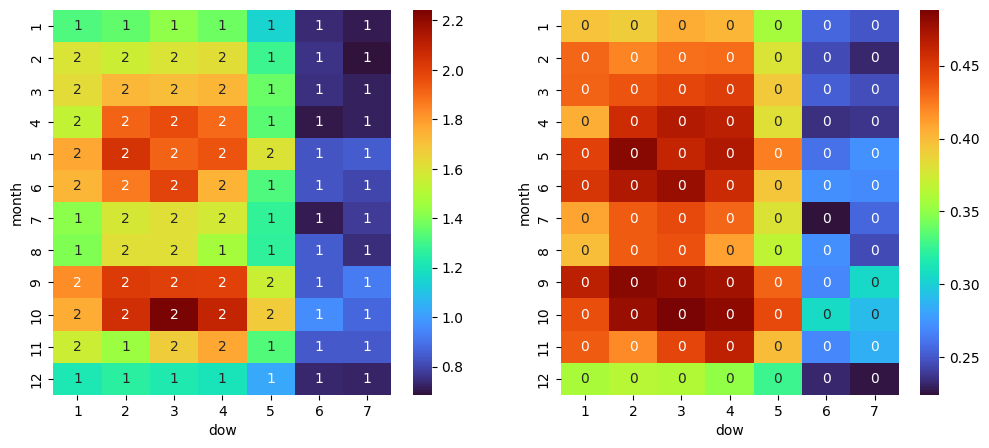

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(
    data = data.pivot_table(index="month", columns="dow", values="v1", aggfunc='mean'), 
    annot = True, 
    cmap = 'turbo',
    # cmap = 'coolwarm',
    fmt = '.0f',
    ax=ax[0])

sns.heatmap(
    data = data.pivot_table(index="month", columns="dow", values="v2", aggfunc = "mean"),
    annot= True,
    cmap= "turbo",
    fmt = ".0f",
    ax = ax[1]
)

Text(0.5, 1.0, 'Distribution of v2 by holiday')

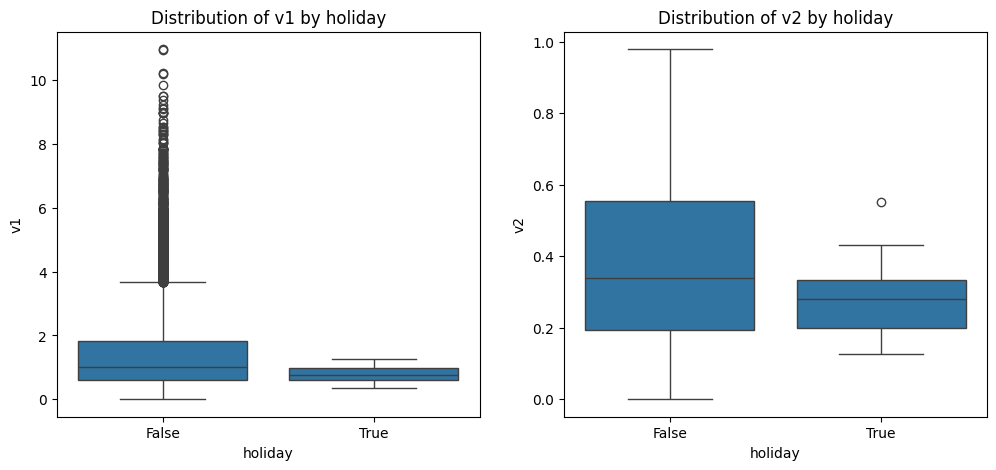

In [24]:
fig, ax = plt.subplots(1, 2, figsize = (12, 5))

sns.boxplot(data= data, x = 'holiday', y = 'v1', ax = ax[0])
ax[0].set_title('Distribution of v1 by holiday')

sns.boxplot(data= data, x = "holiday", y = "v2", ax=ax[1])
ax[1].set_title("Distribution of v2 by holiday")

### <span style="color:blue"><b>3. Model building and prediction</b></span>

#### &nbsp;&nbsp;&nbsp;&nbsp;<span style="color:black"><b>A. Linear regression with seasonality</b></span>

In [25]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24592 entries, 0 to 24591
Data columns (total 12 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   ts       24592 non-null  datetime64[ns]
 1   v1       24592 non-null  float64       
 2   v2       24592 non-null  float64       
 3   year     24592 non-null  int32         
 4   quarter  24592 non-null  int32         
 5   month    24592 non-null  int32         
 6   day      24592 non-null  int32         
 7   dow      24592 non-null  int32         
 8   weekend  24592 non-null  bool          
 9   time     24592 non-null  object        
 10  trend    24592 non-null  int64         
 11  holiday  24592 non-null  bool          
dtypes: bool(2), datetime64[ns](1), float64(2), int32(5), int64(1), object(1)
memory usage: 1.5+ MB


In [26]:
fastor_cols = ["month", "dow", "time", "holiday"]

data[fastor_cols] = data[fastor_cols].astype("category")

In [27]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24592 entries, 0 to 24591
Data columns (total 12 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   ts       24592 non-null  datetime64[ns]
 1   v1       24592 non-null  float64       
 2   v2       24592 non-null  float64       
 3   year     24592 non-null  int32         
 4   quarter  24592 non-null  int32         
 5   month    24592 non-null  category      
 6   day      24592 non-null  int32         
 7   dow      24592 non-null  category      
 8   weekend  24592 non-null  bool          
 9   time     24592 non-null  category      
 10  trend    24592 non-null  int64         
 11  holiday  24592 non-null  category      
dtypes: bool(1), category(4), datetime64[ns](1), float64(2), int32(3), int64(1)
memory usage: 1.2 MB


Train/holdout data

In [28]:
data_holdout = data.loc[data["year"] == 2024, :]
data_train = data.loc[data['year'] < 2024, :]

In [29]:
logo = LeaveOneGroupOut()
groups = data_train.loc[:, "year"].to_numpy()

In [30]:
data_train.loc[:, "year"].unique()

array([2022, 2023])

In [31]:
lin_reg = LinearRegression(fit_intercept=False)

In [32]:
def fit_cv_model_get_rmse(y, X, groups):
    rmse_folds = []
    for train_index, test_index in logo.split(X, y, groups):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        lin_reg.fit(X_train, y_train)
        y_hat = lin_reg.predict(X_test)
        rmse_folds.append(mean_squared_error(y_test, y_hat, squared=False))

    return np.mean(rmse_folds)

##### **Model 1: Linear trend + monthly seasonality**

In [33]:
#Model 1: Linear trend + monthly seasonality
y, X = dmatrices("v1 ~ 1 + trend + month", data_train)

rmse_reg1_v1 = fit_cv_model_get_rmse(y, X, groups)
rmse_reg1_v1

1.3123249410570195

In [34]:
#Model 1: Linear trend + monthly seasonality
y, X = dmatrices("v2 ~ 1 + trend + month", data_train)

rmse_reg1_v2 = fit_cv_model_get_rmse(y, X, groups)
rmse_reg1_v2

0.24013751768736294

##### **Model 2: Linear trend + monthly seasonality + days of week seasonality**

In [35]:
y, X = dmatrices("v1 ~ 1 + trend + month + dow", data_train)

rmse_reg2_v1 = fit_cv_model_get_rmse(y, X, groups)
rmse_reg2_v1

1.3493375297710672

In [36]:
y, X = dmatrices("v2 ~ 1 + trend + month + dow", data_train)

rmse_reg2_v2 = fit_cv_model_get_rmse(y, X, groups)
rmse_reg2_v2

0.2336338396966226

##### **Model 3: Linear trend + monthly seasonality + days of week seasonality + holiday**

In [37]:
y, X = dmatrices("v1 ~ 1 + trend + month + dow + holiday", data_train)

rmse_reg3_v1 = fit_cv_model_get_rmse(y, X, groups)
rmse_reg3_v1

1.3477464087964992

In [38]:
y, X = dmatrices("v2 ~ 1 + trend + month + dow + holiday", data_train)

rmse_reg3_v2 = fit_cv_model_get_rmse(y, X, groups)
rmse_reg3_v2

0.23341609314560063

##### **Model 4: Linear trend + monthly seasonality + days of week seasonality + holiday + time of day seasonality**

In [39]:
y, X = dmatrices("v1 ~ 1 + trend + month + dow + holiday + time", data_train)

rmse_reg4_v1 = fit_cv_model_get_rmse(y, X, groups)
rmse_reg4_v1

0.9064025859073226

In [40]:
y, X = dmatrices("v2 ~ 1 + trend + month + dow + holiday + time", data_train)

rmse_reg4_v2 = fit_cv_model_get_rmse(y, X, groups)
rmse_reg4_v2

0.14681711792440444

##### **Model 5: Linear trend + monthly seasonality + days of week seasonality + time of day seasonality + intereactions**

In [41]:
y, X = dmatrices("v1 ~ 1 + trend + month + dow + holiday + time + month*dow + dow*time", data_train)

rmse_reg5_v1 = fit_cv_model_get_rmse(y, X, groups)
rmse_reg5_v1 

0.7048051794945969

In [42]:
y, X = dmatrices("v2 ~ 1 + trend + month + dow + holiday + time + month*dow + dow*time", data_train)

rmse_reg5_v2 = fit_cv_model_get_rmse(y, X, groups)
rmse_reg5_v2

0.12955129390221978

**Models for V1**

In [43]:
pd.DataFrame(
    [rmse_reg1_v1, rmse_reg2_v1, rmse_reg3_v1, rmse_reg4_v1, rmse_reg5_v1],
    ["Model"+ str(i) for i in range (1, 6)],
    columns=["RMSE for v1"]
    ).round(2)

,RMSE for v1
Model1,1.31
Model2,1.35
Model3,1.35
Model4,0.91
Model5,0.70


**Models for V2**

In [44]:
pd.DataFrame(
    [rmse_reg1_v2, rmse_reg2_v2, rmse_reg3_v2, rmse_reg4_v2, rmse_reg5_v2],
    ["Model"+ str(i) for i in range (1, 6)],
    columns=["RMSE for v2"]
    ).round(2)

,RMSE for v2
Model1,0.24
Model2,0.23
Model3,0.23
Model4,0.15
Model5,0.13


### Evaluate best model on the holdout set

#### **V1**

In [45]:
lin_reg = LinearRegression(fit_intercept = False)

y, X = dmatrices(
    "v1 ~ 1 + trend + month + dow + holiday + time + month*dow + dow*time", 
    data_train,
)

lin_reg.fit(X, y)

_, X_holdout = dmatrices(
    "v1 ~ 1 + trend + month + dow + holiday + time + month*dow + dow*time",
    data_holdout,
)

In [46]:
data_holdout["y_hat_5_v1"] = lin_reg.predict(X_holdout)

In [47]:
rmse_holdout_best = mean_squared_error(
    data_holdout.v1, 
    data_holdout.y_hat_5_v1, 
    squared=False # default: True > returns MSE
)
rmse_holdout_best

0.675459415065588

#### **V2**

In [48]:
lin_reg = LinearRegression(fit_intercept = False)

y, X = dmatrices(
    "v2 ~ 1 + trend + month + dow + holiday + time + month*dow + dow*time", 
    data_train,
)

lin_reg.fit(X, y)

_, X_holdout = dmatrices(
    "v2 ~ 1 + trend + month + dow + holiday + time + month*dow + dow*time",
    data_holdout,
)

In [49]:
data_holdout["y_hat_5_v2"] = lin_reg.predict(X_holdout)

In [50]:
rmse_holdout_best = mean_squared_error(
    data_holdout.v2, 
    data_holdout.y_hat_5_v2, 
    squared=False # default: True > returns MSE
)
rmse_holdout_best

0.10865714232933647

#### Plot best predictions

In [51]:
group = data_holdout.sort_values(by=["time"]).groupby("time")

In [52]:
group.apply(lambda x: mean_squared_error(x.v1, x.y_hat_5_v1, squared=False))
group.apply(lambda x: mean_squared_error(x.v2, x.y_hat_5_v2, squared=False))

time
00:00:00    0.131910
01:00:00    0.105290
02:00:00    0.089654
03:00:00    0.083191
04:00:00    0.078834
05:00:00    0.087333
06:00:00    0.075524
07:00:00    0.101839
08:00:00    0.109897
09:00:00    0.119211
10:00:00    0.127755
11:00:00    0.127157
12:00:00    0.127079
13:00:00    0.128781
14:00:00    0.127744
15:00:00    0.122389
16:00:00    0.118789
17:00:00    0.085379
18:00:00    0.089828
19:00:00    0.085425
20:00:00    0.094717
21:00:00    0.118063
22:00:00    0.114838
23:00:00    0.119667
dtype: float64

In [53]:
rmse_hourly_v1 = pd.DataFrame(
    [
        group.apply(lambda x: mean_squared_error(x.v1, x.y_hat_5_v1, squared=False)),
        group.apply(
            lambda x: mean_squared_error(x.v1, x.y_hat_5_v1, squared=False) / np.mean(x.v1)
        ),
    ],
    index=["RMSE", "RMSE_norm"],
).T.reset_index()

rmse_hourly_v2 = pd.DataFrame(
    [
        group.apply(lambda x: mean_squared_error(x.v2, x.y_hat_5_v2, squared=False)),
        group.apply(
            lambda x: mean_squared_error(x.v2, x.y_hat_5_v2, squared=False) / np.mean(x.v2)
        ),
    ],
    index=["RMSE", "RMSE_norm"],
).T.reset_index()



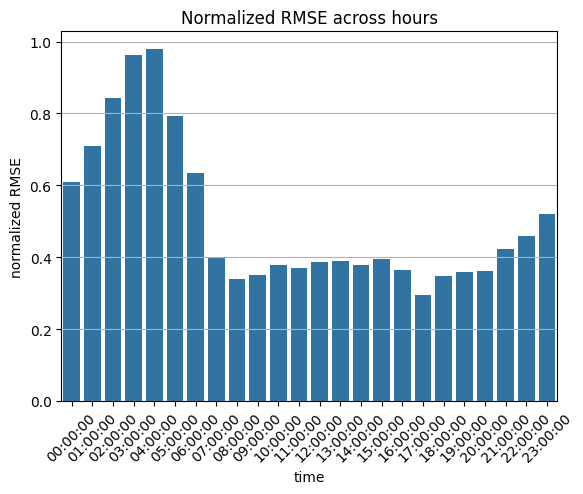

In [54]:
ax = sns.barplot(data = rmse_hourly_v1, x = 'time', y = 'RMSE_norm')
ax.grid(visible = True, axis = 'y')
ax.set_ylabel('normalized RMSE')
ax.set_title('Normalized RMSE across hours')
plt.xticks(rotation=45);

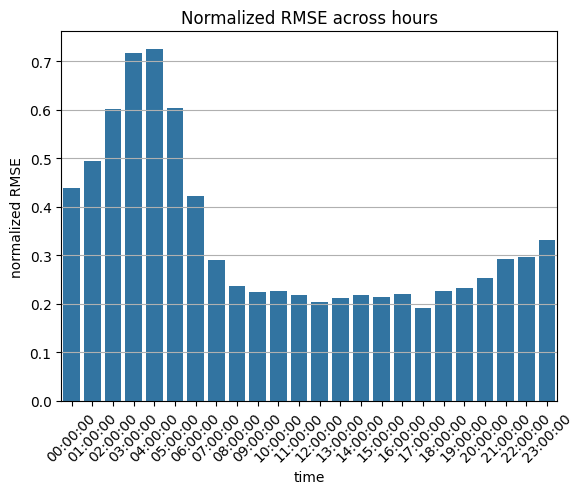

In [55]:
ax = sns.barplot(data = rmse_hourly_v2, x = 'time', y = 'RMSE_norm')
ax.grid(visible = True, axis = 'y')
ax.set_ylabel('normalized RMSE')
ax.set_title('Normalized RMSE across hours')
plt.xticks(rotation=45);

#### &nbsp;&nbsp;&nbsp;&nbsp;<span style="color:black"><b>A. ARIMA</b></span>

Step 1: Check with stationary with ADF test 

v1 and v2 are stationary

In [56]:
from statsmodels.tsa.stattools import adfuller

test1 = adfuller(data["v1"])
test2 = adfuller(data["v2"])

print("ADF test for v1:", test1[0])
print("ADF p-value for v1:", test1[1])

print("ADF test for v2:", test2[0])
print("ADF p-value for v2:", test2[1])

ADF test for v1: -20.691860738533013
ADF p-value for v1: 0.0
ADF test for v2: -20.59835268855503
ADF p-value for v2: 0.0


Step 2: Finding the optimal lag

In [57]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.api import VAR

Text(0.5, 1.0, 'ACF for v1')

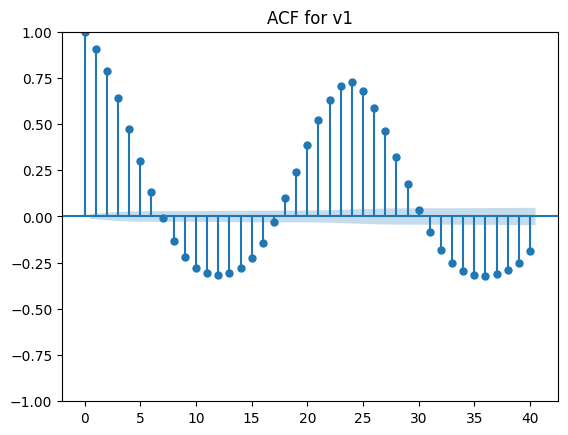

In [58]:
# Plot ACF for v1
plot_acf(data['v1'], lags=40)
plt.title("ACF for v1")

Text(0.5, 1.0, 'ACF for v2')

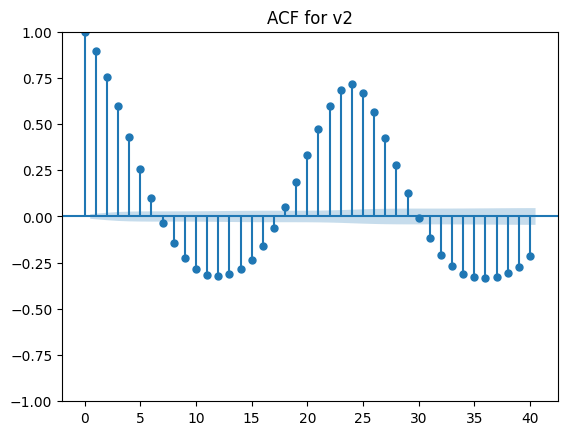

In [59]:
plot_acf(data['v2'], lags=40)
plt.title("ACF for v2")

Step 3: Building the model

Create train and holdout set

In [100]:
# Convert timestamp column to datetime
data["ts"] = pd.to_datetime(data["ts"])
data = data.sort_values("ts")  # Ensure chronological order

# Split holdout data (August, September, October of 2024) and working data (rest of 2024 and before 2024)
data_holdout = data[(data.year == 2024) & (data.month.isin([8, 9, 10]))]
data_work = data[((data.year < 2024) | ((data.year == 2024) & (~data.month.isin([8, 9, 10]))))]

# Define rolling expanding window folds (ONLY 4 FOLDS NOW, including 2024)
folds = [
    ("2022-01-01 00:00", "2022-09-30 23:00", "2022-10-01 00:00", "2022-12-31 23:00"),  # Fold 1 (Training till Sep 2022)
    ("2022-01-01 00:00", "2022-12-31 23:00", "2023-01-01 00:00", "2023-03-31 23:00"),  # Fold 2 (Training till Dec 2022)
    ("2022-01-01 00:00", "2023-03-31 23:00", "2023-04-01 00:00", "2023-06-30 23:00"),  # Fold 3 (Training till Mar 2023)
    ("2022-01-01 00:00", "2023-06-30 23:00", "2023-07-01 00:00", "2024-07-31 23:00"),  # Fold 4 (Training till Jun 2024)
]

# Assign training and test sets
for i, (train_start, train_end, test_start, test_end) in enumerate(folds, 1):
    data_work[f"train{i}"] = (data_work["ts"] >= train_start) & (data_work["ts"] <= train_end)
    data_work[f"test{i}"] = (data_work["ts"] >= test_start) & (data_work["ts"] <= test_end)

# Define holdout set (August, September, October 2024)
data_work["holdout"] = (data_work["year"] == 2024) & (data_work["month"].isin([8, 9, 10]))

print(data_work.head())

                   ts        v1        v2  year  quarter month  day dow  \
0 2022-01-01 00:00:00  0.999036  0.318587  2022        1     1    1   6   
1 2022-01-01 01:00:00  0.695036  0.265836  2022        1     1    1   6   
2 2022-01-01 02:00:00  0.764995  0.320261  2022        1     1    1   6   
3 2022-01-01 03:00:00  0.297017  0.064074  2022        1     1    1   6   
4 2022-01-01 04:00:00  0.366184  0.083961  2022        1     1    1   6   

   weekend      time  ...  holiday train1  test1  train2  test2  train3  \
0     True  00:00:00  ...     True   True  False    True  False    True   
1     True  01:00:00  ...    False   True  False    True  False    True   
2     True  02:00:00  ...    False   True  False    True  False    True   
3     True  03:00:00  ...    False   True  False    True  False    True   
4     True  04:00:00  ...    False   True  False    True  False    True   

   test3  train4  test4  holdout  
0  False    True  False    False  
1  False    True  False    F

Dummies for seasonality (month, day of week, hours)

In [74]:
data_work["month"].value_counts()

month
7     1488
8     1488
10    1488
1     1487
3     1486
5     1455
9     1440
11    1440
4     1438
12    1425
6     1368
2     1344
Name: count, dtype: int64

In [129]:
X_month = pd.get_dummies(data_work['month'], drop_first=True).astype(int)
X_dow = pd.get_dummies(data_work['dow'], drop_first=True).astype(int)
X_time = pd.get_dummies(data_work['time'], drop_first=True).astype(int)

In [130]:
X = pd.concat([X_month, X_dow, X_time], axis=1)
X.columns = X.columns.astype(str)

In [132]:
X1 = pd.concat([X_month, X_dow, X_time], axis=1)
X1.columns = X1.columns.astype(str)

trend = np.arange(1, len(X1) + 1)  
# Add this trend to your existing features
X1['trend'] = trend


**Model 1: ARIMA(1,1,2) for v1, ARIMA(1,1,5) for v2**

In [61]:
#Model for v1
auto_arima_m1_v1 = auto_arima(
    y = data_train.v1,
    start_p = 0,
    max_p = 1,  # without this constrain, python returns a higher AR order
    # max_order=0,
    seasonal = False
)

In [62]:
auto_arima_m1_v1

ARIMA(order=(1, 1, 2), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [63]:
auto_arima_m1_v1.get_params()

{'maxiter': 50,
 'method': 'lbfgs',
 'order': (1, 1, 2),
 'out_of_sample_size': 0,
 'scoring': 'mse',
 'scoring_args': {},
 'seasonal_order': (0, 0, 0, 0),
 'start_params': None,
 'suppress_warnings': True,
 'trend': None,
 'with_intercept': False}

In [ ]:
mse_1_v1 = []

for i in range(1, 5):  # 4 folds
    print(f"Training fold {i}...")

    # Get train-test sets
    data_train = data_work[data_work[f"train{i}"]]
    data_test = data_work[data_work[f"test{i}"]]

    # Fit ARIMA model
    auto_arima_m1_v1 = auto_arima(data_train.v1, seasonal=False, stepwise=True, suppress_warnings=True)
    model1 = ARIMA(data_train.v1, order=auto_arima_m1_v1.get_params()["order"]).fit()

    # Forecast next 720 hours (3 months)
    phat = model1.forecast(steps=24 * 90)  

    # Compare with actual test values
    actual_values = data_test.v1.values[:24 * 90]  

    # Debugging: Check shape of both arrays
    print(f"Fold {i}: phat shape = {phat.shape}, actual_values shape = {actual_values.shape}")

    # Ensure both arrays have the same length
    min_len = min(len(actual_values), len(phat))
    actual_values = actual_values[:min_len]
    phat = phat[:min_len]

    # Compute squared error
    errsq = np.square(actual_values - phat)

    # Store MSE
    mse_1_v1.append(np.mean(errsq))

# Compute RMSE
rmse_cv_m1_v1 = np.sqrt(np.mean(mse_1_v1))
print(f"Cross-validated RMSE: {rmse_cv_m1_v1:.4f}")

Training fold 1...
Fold 1: phat shape = (2160,), actual_values shape = (2145,)
Training fold 2...


In [ ]:
#Model for v2
auto_arima_m1_v2 = auto_arima(
    y = data_train.v2,
    start_p = 0,
    max_p = 1,  # without this constrain, python returns a higher AR order
    # max_order=0,
    seasonal = False
)

In [ ]:
auto_arima_m1_v2

ARIMA(order=(1, 1, 5), scoring_args={}, suppress_warnings=True)

In [ ]:
mse_1_v2 = []

for i in range(1, 5):  # 4 folds
    print(f"Training fold {i}...")

    # Get train-test sets
    data_train = data_work[data_work[f"train{i}"]]
    data_test = data_work[data_work[f"test{i}"]]

    # Fit ARIMA model
    auto_arima_m1_v2 = auto_arima(data_train.v2, seasonal=False, stepwise=True, suppress_warnings=True)
    model1_v2 = ARIMA(data_train.v2, order=auto_arima_m1_v2.get_params()["order"]).fit()

    # Forecast next 720 hours (3 months)
    phat = model1_v2.forecast(steps=24 * 90)  

    # Compare with actual test values
    actual_values = data_test.v1.values[:24 * 90]  

    # Debugging: Check shape of both arrays
    print(f"Fold {i}: phat shape = {phat.shape}, actual_values shape = {actual_values.shape}")

    # Ensure both arrays have the same length
    min_len = min(len(actual_values), len(phat))
    actual_values = actual_values[:min_len]
    phat = phat[:min_len]

    # Compute squared error
    errsq = np.square(actual_values - phat)

    # Store MSE
    mse_1_v2.append(np.mean(errsq))

# Compute RMSE
rmse_cv_m1_v2 = np.sqrt(np.mean(mse_1_v2))
print(f"Cross-validated RMSE: {rmse_cv_m1_v2:.4f}")

Training fold 1...
Training fold 2...
Training fold 3...
Training fold 4...
Cross-validated RMSE: 1.7505


**Model 2: ARIMA(0,1,2) with seasonality for v1, ARIMA(1,1,5) with seasonality for v2**

In [96]:
auto_arima_m2_v1 = auto_arima(
    y = data_work.v1, 
    X = X,
    seasonal = False,
    start_p = 0,
    max_p= 1
)

In [97]:
auto_arima_m2_v1

ARIMA(order=(0, 1, 2), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [ ]:
mse_2_v1 = []

for i in range(1, 5):  # 4 folds
    print(f"Training fold {i}...")

    # Get train-test sets
    data_train = data_work[data_work[f"train{i}"]]
    data_test = data_work[data_work[f"test{i}"]]

    # Fit ARIMA model
    auto_arima_m2_v1 = auto_arima(data_train.v1, seasonal=False, stepwise=True, suppress_warnings=True)
    model2_v1 = ARIMA(data_train.v1, order=auto_arima_m2_v1.get_params()["order"]).fit()

    # Forecast next 720 hours (3 months)
    phat = model1.forecast(steps=24 * 90)  

    # Compare with actual test values
    actual_values = data_test.v1.values[:24 * 90]  

    # Debugging: Check shape of both arrays
    print(f"Fold {i}: phat shape = {phat.shape}, actual_values shape = {actual_values.shape}")

    # Ensure both arrays have the same length
    min_len = min(len(actual_values), len(phat))
    actual_values = actual_values[:min_len]
    phat = phat[:min_len]

    # Compute squared error
    errsq = np.square(actual_values - phat)

    # Store MSE
    mse_2_v1.append(np.mean(errsq))

# Compute RMSE
rmse_cv_m2_v1 = np.sqrt(np.mean(mse_2_v1))
print(f"Cross-validated RMSE: {rmse_cv_m2_v1:.4f}")

Training fold 1...
Training fold 2...
Training fold 3...
Training fold 4...
Cross-validated RMSE: 1.3949


In [ ]:
auto_arima_m2_v2 = auto_arima(
    y = data_work.v2, 
    X = X,
    seasonal = False,
    start_p = 0,
    max_p= 1
)

In [82]:
auto_arima_m2_v2

ARIMA(order=(1, 1, 5), scoring_args={}, suppress_warnings=True)

In [ ]:
mse_2_v2 = []

for i in range(1, 5):  # 4 folds
    print(f"Training fold {i}...")

    # Get train-test sets
    data_train = data_work[data_work[f"train{i}"]]
    data_test = data_work[data_work[f"test{i}"]]

    # Fit ARIMA model
    auto_arima_m2_v2 = auto_arima(data_train.v2, seasonal=False, stepwise=True, suppress_warnings=True)
    model2_v2 = ARIMA(data_train.v2, order=auto_arima_m2_v2.get_params()["order"]).fit()

    # Forecast next 720 hours (3 months)
    phat = model2_v2.forecast(steps=24 * 90)  

    # Compare with actual test values
    actual_values = data_test.v2.values[:24 * 90]  

    # Debugging: Check shape of both arrays
    print(f"Fold {i}: phat shape = {phat.shape}, actual_values shape = {actual_values.shape}")

    # Ensure both arrays have the same length
    min_len = min(len(actual_values), len(phat))
    actual_values = actual_values[:min_len]
    phat = phat[:min_len]

    # Compute squared error
    errsq = np.square(actual_values - phat)

    # Store MSE
    mse_2_v2.append(np.mean(errsq))

# Compute RMSE
rmse_cv_m1_v1 = np.sqrt(np.mean(mse_2_v2))
print(f"Cross-validated RMSE: {rmse_cv_m2_v2:.4f}")

**Model 3: ARIMA(2,0,0) with seasonality and trend for v1 and**

In [133]:
auto_arima_m3_v1 = auto_arima(
    y = data_work.v1,
    X = X1,
    seasonal = False,
    start_p = 0,
    max_p = 2
)

In [134]:
auto_arima_m3_v1

ARIMA(order=(2, 0, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [135]:
auto_arima_m3_v2 = auto_arima(
    y = data_work.v2,
    X = X1,
    seasonal = False,
    start_p = 0,
    max_p = 2
)

In [136]:
auto_arima_m3_v2

ARIMA(order=(2, 0, 0), scoring_args={}, suppress_warnings=True)

#### &nbsp;&nbsp;&nbsp;&nbsp;<span style="color:black"><b>A. VAR</b></span>

The best model prediction